In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
invoice_opportunities = pd.read_excel('shared_data_read_only/Invoice and Opportunities.xlsx')

invoice_opportunities.head()

,Type,Reference Nbr.,Customer,Amount,Date,Opportunity ID
0,Invoice,FC0004608,C06507,5000.0,2023-10-10,4504
1,Invoice,FC0004607,C01388,241253.0,2023-10-09,1863
2,Invoice,FC0004605,C19104,83954.0,2023-10-06,5708
3,Invoice,FC0004600,C10528,3000.0,2023-06-23,5617
4,Invoice,FC0004598,C01196,54531.0,2023-10-09,5829


In [3]:
# Convert 'Date' to a datetime object (if it's not already)
invoice_opportunities['Date'] = pd.to_datetime(invoice_opportunities['Date'])

# Find the first and last date in the dataset
first_date = invoice_opportunities['Date'].min()
last_date = invoice_opportunities['Date'].max()

print("First Date:", first_date)
print("Last Date:", last_date)

First Date: 2020-01-01 00:00:00
Last Date: 2023-10-10 00:00:00


In [4]:
# lack of data before 2021, we take 2021 onwards

invoice_opportunities = invoice_opportunities[invoice_opportunities['Date'] >= pd.to_datetime('2021-01-01')]

In [5]:
invoice_opportunities.head()

,Type,Reference Nbr.,Customer,Amount,Date,Opportunity ID
0,Invoice,FC0004608,C06507,5000.0,2023-10-10,4504
1,Invoice,FC0004607,C01388,241253.0,2023-10-09,1863
2,Invoice,FC0004605,C19104,83954.0,2023-10-06,5708
3,Invoice,FC0004600,C10528,3000.0,2023-06-23,5617
4,Invoice,FC0004598,C01196,54531.0,2023-10-09,5829


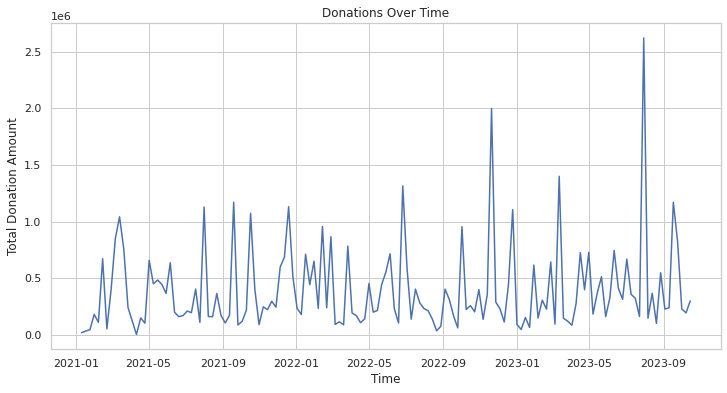

In [6]:
# Set 'Assignment Date' as the index

invoice_opportunities.set_index('Date', inplace=True)

# Resample the data to aggregate by a specific time frequency, e.g., monthly
# You can change 'M' to other time frequencies like 'D' (daily), 'W' (weekly), etc.
weekly_donations = invoice_opportunities.resample('W').sum()

# Create a time series plot to visualize seasonality
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.lineplot(x=weekly_donations.index, y='Amount', data=weekly_donations)
plt.title('Donations Over Time')
plt.xlabel('Time')
plt.ylabel('Total Donation Amount')
plt.show()

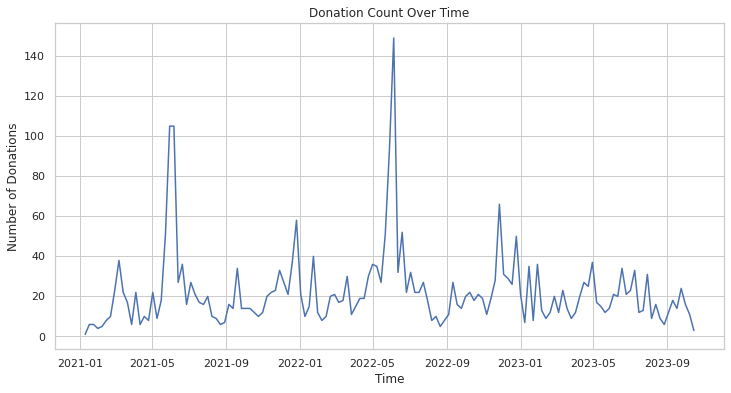

In [7]:
# Create a new DataFrame with a count of donations per month
weekly_donation_counts = invoice_opportunities.resample('W').size().reset_index(name='Donation Count')

# Create a time series plot to visualize the number of donations per month
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.lineplot(x='Date', y='Donation Count', data=weekly_donation_counts)
plt.title('Donation Count Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Donations')
plt.show()

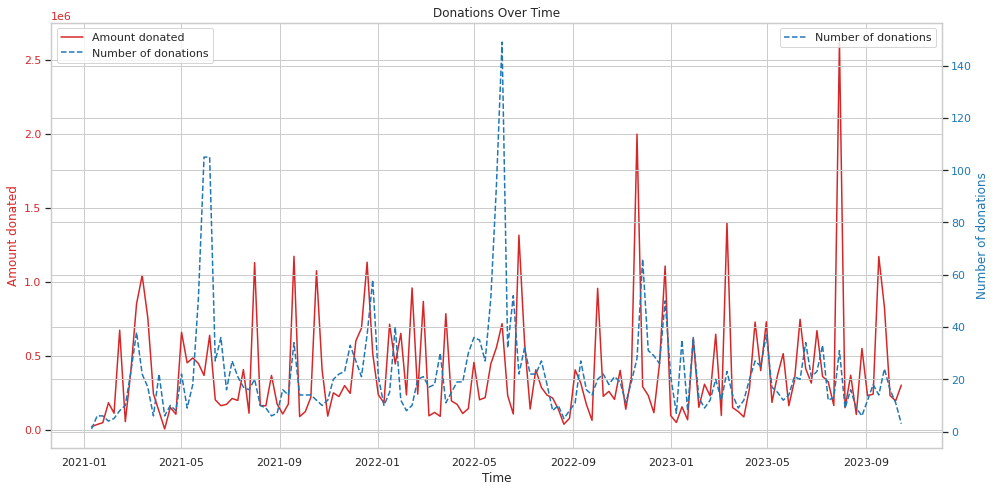

In [12]:
# Increase the figure size for a wider graph
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot 'Amount donated' in red with a solid line
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Amount donated', color=color)
sns.lineplot(x=weekly_donations.index, y='Amount', data=weekly_donations, ax=ax1, color=color, label='Amount donated')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for 'Number of donations'
ax2 = ax1.twinx()

# Plot 'Number of donations' in blue with a dashed line
color = 'tab:blue'
ax2.set_ylabel('Number of donations', color=color)
sns.lineplot(x='Date', y='Donation Count', data=weekly_donation_counts, ax=ax2, color=color, label='Number of donations', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Set titles and labels
plt.title('Donations Over Time')
ax1.set_xlabel('Time')

# Add legend to differentiate the lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust the layout to prevent clipping of the ylabel
fig.tight_layout()

# Show the plot
plt.show()


So, since I want to make my plots look better, I take my original dataset invoice_opportunities group by weeks and have the different columns:
- mean of the donations that month 
- the rate: amount of donations / number donations
- the "rolling mean", "moving avg"
- the standard deviation of the amount of donations 
And then plot each different variable in a different table.

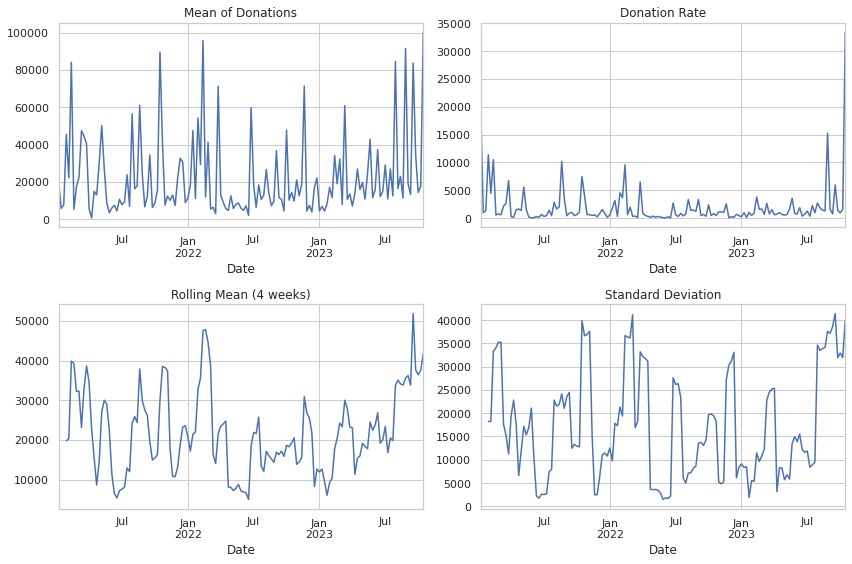

In [14]:
# Load your dataset, replace 'your_data.csv' with the actual filename.
invoice_opportunities = pd.read_excel('shared_data_read_only/Invoice and Opportunities.xlsx')

# Convert the 'Date' column to a datetime object
invoice_opportunities['Date'] = pd.to_datetime(invoice_opportunities['Date'])

# lack of data before 2021, we take 2021 onwards
invoice_opportunities = invoice_opportunities[invoice_opportunities['Date'] >= pd.to_datetime('2021-01-01')]

# Group by weeks and calculate statistics
weekly_stats = invoice_opportunities.resample('W', on='Date').agg({
    'Amount': 'mean',                            # Mean of donations
    'Opportunity ID': 'count',                   # Number of donations
})

# Calculate the rate: amount of donations / number donations
weekly_stats['Rate'] = weekly_stats['Amount'] / weekly_stats['Opportunity ID']

# Calculate the rolling mean (moving average) using a window size of 4 weeks
weekly_stats['Rolling Mean'] = weekly_stats['Amount'].rolling(window=4).mean()

# Calculate the standard deviation of the amount of donations
weekly_stats['Std Deviation'] = weekly_stats['Amount'].rolling(window=4).std()

# Create separate tables for each statistic
mean_table = weekly_stats[['Amount']]
rate_table = weekly_stats[['Rate']]
rolling_mean_table = weekly_stats[['Rolling Mean']]
std_deviation_table = weekly_stats[['Std Deviation']]

# Plot the tables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

mean_table.plot(ax=axes[0, 0], title='Mean of Donations', legend=False)
rate_table.plot(ax=axes[0, 1], title='Donation Rate', legend=False)
rolling_mean_table.plot(ax=axes[1, 0], title='Rolling Mean (4 weeks)', legend=False)
std_deviation_table.plot(ax=axes[1, 1], title='Standard Deviation', legend=False)

plt.tight_layout()
plt.show()


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


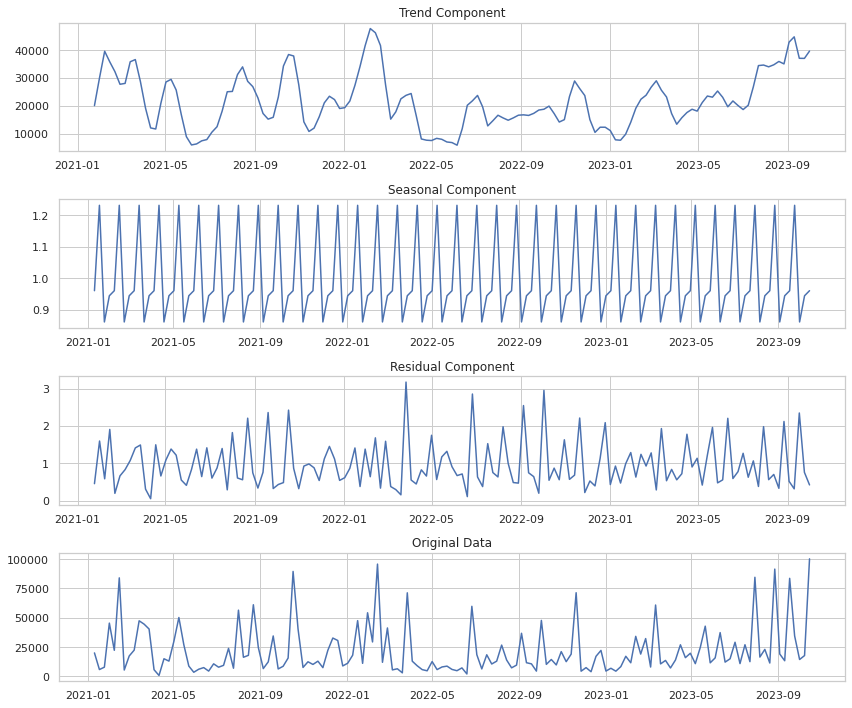

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the mean of donations
result = seasonal_decompose(weekly_stats['Amount'], model='multiplicative', freq=4)  # Assuming a yearly seasonality (52 weeks)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
ax1.plot(result.trend, label='Trend')
ax1.set_title('Trend Component')
ax2.plot(result.seasonal, label='Seasonal')
ax2.set_title('Seasonal Component')
ax3.plot(result.resid, label='Residuals')
ax3.set_title('Residual Component')
ax4.plot(weekly_stats['Amount'], label='Original Data')
ax4.set_title('Original Data')
plt.tight_layout()
plt.show()


Certainly, seasonal decomposition is a technique used to separate a time series into its individual components, which are typically the trend, seasonality, and residuals (or error terms). Understanding these components can help you identify and analyze the different underlying patterns within your time series data.

The main components of seasonal decomposition are:

1. **Trend**: This component represents the long-term progression or direction in your time series. It shows whether the values are increasing, decreasing, or relatively stable over time.

2. **Seasonality**: Seasonality refers to repeating patterns or cycles that occur at fixed intervals. For example, in monthly data, you might observe a yearly seasonality pattern, such as increased donations during the holiday season or a weekly seasonality pattern with more donations on weekends.

3. **Residuals**: Residuals, also called errors, represent the noise or random fluctuations in the data that are not explained by the trend and seasonality components. Residuals are essentially what's left after removing the trend and seasonality.

Here's a step-by-step explanation of the code I provided for seasonal decomposition:

1. **Import Required Libraries**:
   ```python
   from statsmodels.tsa.seasonal import seasonal_decompose
   ```

2. **Decompose the Time Series**:
   ```python
   result = seasonal_decompose(weekly_stats['Amount'], model='multiplicative', freq=52)
   ```

   - `weekly_stats['Amount']` is the time series data for which you want to decompose the components.
   - `model='multiplicative'` specifies that the seasonality is multiplicative (you can use `'additive'` if seasonality is additive).
   - `freq=52` assumes a yearly seasonality with 52 weeks. You can adjust the frequency based on your data's seasonality period.

3. **Plot the Decomposed Components**:

   The decomposition produces four components:

   - **Trend Component**: This is the long-term trend in the data, showing whether the donations are increasing or decreasing over time.

   - **Seasonal Component**: This component represents the seasonality, showing the repetitive patterns in the data.

   - **Residual Component**: These are the unexplained fluctuations in the data after removing trend and seasonality. Residuals can be used to analyze noise or irregular patterns.

   - **Original Data**: This is the actual time series data.

   The code provided plots all these components to help you visually inspect them and understand their characteristics.

Understanding the results of seasonal decomposition can provide valuable insights into your data, such as identifying the strength and periodicity of seasonality, the overall trend, and any unusual fluctuations or anomalies in the data. It's a useful step in time series analysis to gain a better understanding of your dataset before further modeling or analysis.

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


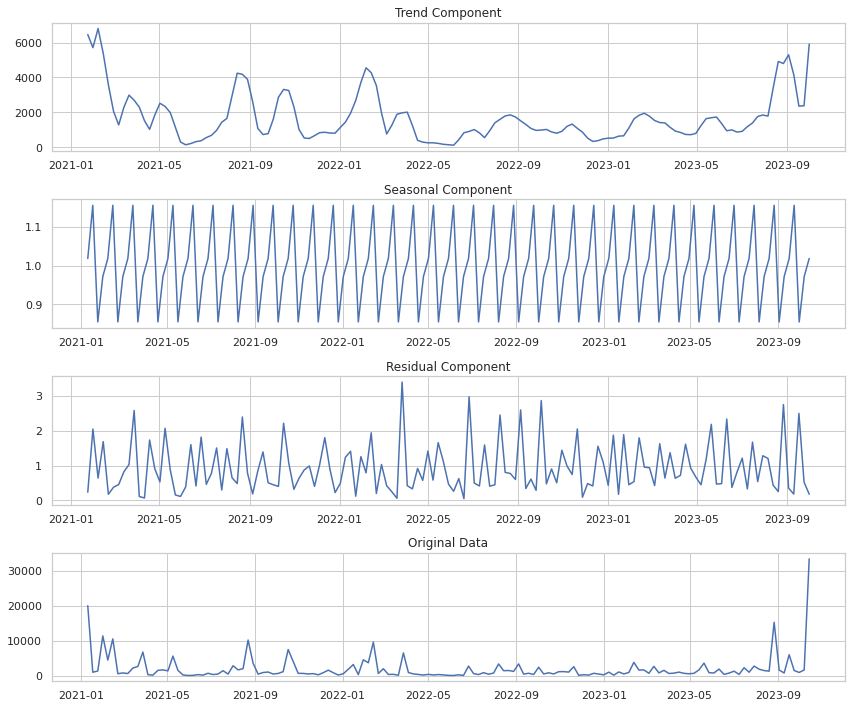

In [21]:
# Decompose the mean of donations
result = seasonal_decompose(weekly_stats['Rate'], model='multiplicative', freq=4)  # Assuming a yearly seasonality (52 weeks)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
ax1.plot(result.trend, label='Trend')
ax1.set_title('Trend Component')
ax2.plot(result.seasonal, label='Seasonal')
ax2.set_title('Seasonal Component')
ax3.plot(result.resid, label='Residuals')
ax3.set_title('Residual Component')
ax4.plot(weekly_stats['Rate'], label='Original Data')
ax4.set_title('Original Data')
plt.tight_layout()
plt.show()

I want to create a streamlit app for the association to check better their data and be able to data analysis more efficiently. Can you write me the code of a basic streamlit app where I can go to 4 different pages:
1. Home
2. Map analysis
3. Time analysis
4. Partners analysis

In [ ]:
elif selected_page == "Time Analysis":
    st.title("Time Analysis Page")
    st.write("This is the Time Analysis Page. You can analyze time-series data or patterns here.")
    
    # ... (previous code for filters and other plots)

    # Additional Analysis (Mean, Rate, Rolling Mean, Std Deviation)
    st.header("Additional Analysis")
    
    # Load your dataset, replace 'your_data.csv' with the actual filename.
    invoice_opportunities = pd.read_excel('shared_data_read_only/Invoice and Opportunities.xlsx')

    # Convert the 'Date' column to a datetime object
    invoice_opportunities['Date'] = pd.to_datetime(invoice_opportunities['Date'])

    # Filter data for 2021 onwards
    invoice_opportunities = invoice_opportunities[invoice_opportunities['Date'] >= pd.to_datetime('2021-01-01')]

    # Group by weeks and calculate statistics
    weekly_stats = invoice_opportunities.resample('W', on='Date').agg({
        'Amount': 'mean',                            # Mean of donations
        'Opportunity ID': 'count',                   # Number of donations
    })

    # Calculate the rate: amount of donations / number donations
    weekly_stats['Rate'] = weekly_stats['Amount'] / weekly_stats['Opportunity ID']

    # Calculate the rolling mean (moving average) using a window size of 4 weeks
    weekly_stats['Rolling Mean'] = weekly_stats['Amount'].rolling(window=4).mean()

    # Calculate the standard deviation of the amount of donations
    weekly_stats['Std Deviation'] = weekly_stats['Amount'].rolling(window=4).std()

    # Create separate tables for each statistic
    mean_table = weekly_stats[['Amount']]
    rate_table = weekly_stats[['Rate']]
    rolling_mean_table = weekly_stats[['Rolling Mean']]
    std_deviation_table = weekly_stats[['Std Deviation']]

    # Create subplots for tables
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot the tables
    mean_table.plot(ax=axes[0, 0], title='Mean of Donations', legend=False)
    rate_table.plot(ax=axes[0, 1], title='Donation Rate', legend=False)
    rolling_mean_table.plot(ax=axes[1, 0], title='Rolling Mean (4 weeks)', legend=False)
    std_deviation_table.plot(ax=axes[1, 1], title='Standard Deviation', legend=False)

    plt.tight_layout()
    st.pyplot(fig)


In [ ]:

    elif selected_approach == "Partner Type Analysis":
        # Filter by Partner Type
        selected_partner_type = st.sidebar.selectbox("Select Partner Type", business_account['Partner type'].unique())
        # Filter data for the selected partner type
        filtered_data = business_account[business_account['Partner type'] == selected_partner_type]

    elif selected_approach == "Financial Analysis":
        # Filter by Time Period
        start_date = st.sidebar.date_input("Start Date", pd.to_datetime('2021-01-01'))
        end_date = st.sidebar.date_input("End Date", pd.to_datetime('2023-10-10'))
        # Filter data for the selected time period
        filtered_data = business_account[
            (business_account['Last Modified On'] >= start_date) & (business_account['Last Modified On'] <= end_date)
        ]

    elif selected_approach == "Ownership Analysis":
        # Filter by Owner Name
        selected_owner = st.sidebar.selectbox("Select Owner Name", business_account['Owner Name'].unique())
        # Filter data for the selected owner
        filtered_data = business_account[business_account['Owner Name'] == selected_owner]

    elif selected_approach == "Categorical Analysis":
        # Filter by Categorical Column
        selected_category = st.sidebar.selectbox("Select a Category", business_account['Class'].unique())
        # Filter data for the selected category
        filtered_data = business_account[business_account['Class'] == selected_category]

    # Display analysis results
    st.subheader(selected_approach)
    st.write("Total Number of Customers:", len(filtered_data))
    st.write("Total Amount Spent:", filtered_data['Amount'].sum())

# Run the Streamlit app

